In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import ceil

In [349]:
class DNN:
    
    def __init__(self, layers, acts, lr=0.001, iters=1500, mini_batch_size=128):
        self.layers = layers
        self.lr = lr
        self.iters = iters
        self.acts = acts
        self.L = len(self.layers)
        self.epsilon = 1e-8
        self.mbs = mini_batch_size
        self.b1 = 0.9
        
        self.A, self.Z, self.W, self.B, self.Ahat, self.Y, self.DY = {}, {}, {}, {}, {}, {}, {}
        self.gamma, self.beta, self.dgamma, self.dbeta, self.DZ = {}, {}, {}, {}, {}
        self.DW, self.mu, self.var, self.DA, self.mean, self.variance = {}, {}, {}, {}, {}, {}
        self.AP, self.ZP, self.APhat, self.YP = {}, {}, {}, {}
        
        self.costs, self.accuracy, self.mbx, self.mby = [], [], [], []
        
        self.x, self.y, self.m, self.xp, self.yp = None, None, None, None, None
        
        self.activations = {'sm' : self.softmax, 'r' : self.relu, 't' : self.tanh, 's' : self.sigmoid}
        self.diff_activations = {'r' : self.diff_relu, 't' : self.diff_tanh, 's' : self.diff_sigmoid}
        
    def fit(self, x, y):
        
        self.x = x.T
        self.xp = x
        self.y = self.onehotencode(y).T
        self.yp = y
        
        self.initialize_weights()
        self.create_mini_batches()
        self.optimize_weights()
        
        plt.figure(1)
        plt.plot(nn.costs, color='g', alpha=0.7)
        plt.grid(1)
        plt.xlabel('Epochs')
        plt.ylabel('Costs')
        
        plt.figure(2)
        plt.plot(nn.accuracy, color='r', alpha=0.7)
        plt.grid(1)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    
    def initialize_weights(self):
        
        for i in range(1, self.L):
            
            self.W[i] = np.random.random((self.layers[i], self.layers[i-1])) * np.sqrt(2 / self.layers[i-1])
            self.B[i] = np.random.random((self.layers[i], 1)) * 0.001
            
            self.gamma[i] = np.random.random(self.B[i].shape) * np.sqrt(2 / self.layers[i-1])
            self.beta[i] = np.random.random(self.B[i].shape) * 0.001
            
            self.dgamma[i] = np.zeros(self.B[i].shape) 
            self.dbeta[i] = np.zeros(self.B[i].shape) 
            
            self.mu[i] = np.zeros_like(self.B[i])
            self.var[i] = np.zeros_like(self.B[i])
            
            self.mean[i] = np.zeros_like(self.B[i])
            self.variance[i] = np.zeros_like(self.B[i])
            
    def forward_propagation(self):
        
        for i in range(1, self.L):
            self.Z[i] = np.dot(self.W[i], self.Y[i-1])
            self.A[i] = self.activations[self.acts[i-1]] (self.Z[i])
            self.forward_batch(i)
            
    def forward_batch(self, i):
        
        self.mu[i] = np.mean(self.A[i], axis=1, keepdims=True)
        self.var[i] = np.var(self.A[i], axis=1, keepdims=True)
        
        self.mean[i] = 0.9*self.mean[i] + 0.1*self.mu[i]
        self.variance[i] = 0.9*self.variance[i] + 0.1*self.var[i]
        
        var = np.sqrt(self.var[i] + self.epsilon)
        self.Ahat[i] = (self.A[i] - self.mu[i]) / var
        self.Y[i] = self.gamma[i]*self.Ahat[i] + self.beta[i]
        
    def backward_propagation(self):
        
        for i in range(1, self.L)[::-1]:
            
            if i == self.L-1:
                self.DZ[i] = self.A[i] - self.y
                
            else:
                self.DY[i] = np.dot(self.W[i+1].T, self.DZ[i+1])
                self.backward_batch(i)
                self.DZ[i] = self.DA[i] * self.diff_activations[self.acts[i-1]] (self.Z[i])
            
            self.DW[i] = np.dot(self.DZ[i], self.Y[i-1].T) / self.m
            
    def backward_batch(self, i):
        
        dahat = self.DY[i]*self.gamma[i]
        self.dgamma[i] = np.sum(self.DY[i]*self.Ahat[i], axis=1, keepdims=True)
        self.dbeta[i] = np.sum(self.DY[i], axis=1, keepdims=True)
        
        m = self.m
        var = self.var[i] + self.epsilon
        t1 = 1/(np.sqrt(var)*m)
        t2 = (m*dahat)-np.sum(dahat, axis=1, keepdims=1)-(self.Ahat[i]*np.sum(dahat*self.Ahat[i], axis=1, keepdims=1))
        self.DA[i] = t1 * t2
    
    def optimize_weights(self):
        
        for _ in range(self.iters):
            
            for x, y in zip(self.mbx, self.mby):
                
                self.x = x
                self.y = y
                self.m = x.shape[1]
                self.Y[0] = self.x
                
                self.forward_propagation()
                self.backward_propagation()
                
                for i in range(1, self.L):
                    self.W[i] -= self.lr * self.DW[i]
                    
                    self.gamma[i] -= self.lr * self.dgamma[i]
                    self.beta[i] -= self.lr * self.dbeta[i]
                    
            self.costs.append(self.compute_cost(self.A[self.L-1], self.y))
            self.accuracy.append(self.compute_accuracy(self.predict(self.xp), self.yp))
    
    def compute_cost(self, ypred, ytrue):
        cost = - np.sum( np.sum( ytrue*np.log(ypred+self.epsilon), axis=0 ) ) / self.m
        return cost
    
    def predict(self, x):
        
        self.YP[0] = x.T
        for i in range(1, self.L):
            self.ZP[i] = self.W[i] @ self.YP[i-1]
            self.AP[i] = self.activations[self.acts[i-1]](self.ZP[i])
            self.forward_batch_test(i)
        return self.AP[i].argmax(axis=0)
            
    def forward_batch_test(self, i):
        self.APhat[i] = (self.AP[i] - self.mean[i]) / np.sqrt(self.variance[i] + self.epsilon)
        self.YP[i] = self.gamma[i] * self.APhat[i] + self.beta[i]
    
    def compute_accuracy(self, ypred, ytrue):
        acc = np.sum(ypred==ytrue) / ytrue.size
        return acc*100
    
    def softmax(self, z):
        t = np.exp(z)
        return t/np.sum(t, axis=0)
        
    def relu(self, z):
        return np.maximum(0, z)
    
    def diff_relu(self, z):
        return np.where(z >= 0, 1, 0)
    
    def tanh(self, z):
        return np.tanh(z)
    
    def diff_tanh(self, z):
        return 1 - np.square(self.tanh(z))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def diff_sigmoid(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def create_mini_batches(self):
        start, end = 0, self.mbs
        if self.mbs < self.x.shape[1]:
            for i in range(ceil(self.x.shape[1] / self.mbs)):
                if i == ceil(self.x.shape[1] / self.mbs)-1:
                    self.mbx.append(self.x[:, start:])
                    self.mby.append(self.y[:, start:])
                else:
                    self.mbx.append(self.x[:, start:end])
                    self.mby.append(self.y[:, start:end])
                start += self.mbs
                end += self.mbs
        else:
            self.mbx.append(self.x)
            self.mby.append(self.y)
            
    def onehotencode(self, y):
        labels = len(np.unique(y))
        encoded_y = np.zeros((y.shape[0], labels))
        for i in range(y.shape[0]):
            encoded_y[i, y[i]] = 1
        return encoded_y

In [93]:
data = pd.read_csv('Social_Network_Ads.csv')
x = StandardScaler().fit_transform(data.iloc[:, [2,3]].values)
y = data.iloc[:, -1].values

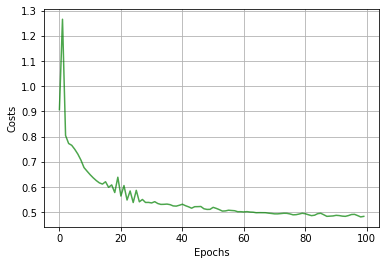

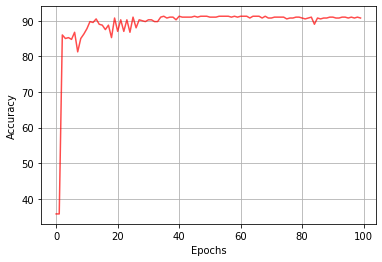

In [361]:
nn = DNN([2,25,10,35,2], ['r', 'r', 'r', 'sm'], iters=100, lr=0.05, mini_batch_size=256)
nn.fit(x,y)

In [362]:
((np.sum(nn.predict(x) == y)) / 400) * 100

90.75